This follows from [elliptical_sersic_fitting](elliptical_sersic_fitting.ipynb)  - the goal is to see if with a simpler foreground population that is fully analytic we still get the awkward mixing with uniform contaminant problem.

In [2]:
# needed on macs due to subtle multiprocessing differences used in dynesty
import sys
if sys.platform == 'darwin':
    import multiprocessing
    multiprocessing.set_start_method('fork')

In [3]:
import numpy as np
np.seterr(all='ignore')


import sympy

import dynesty
from dynesty import plotting as dyplot


from tqdm.notebook import tqdm

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

Use a population for the galaxy that is gaussian and in the middle of a circular region - this ensures easy analytic integrals.

In [5]:
N,σ,r,Re=sympy.symbols('N,σ,r,Re',real=True, positive=True)
i = sympy.integrate(N*sympy.exp(-r**2/(2*σ**2))*r, (r, 0, sympy.oo))*2*sympy.pi
Nsoln = sympy.solve(sympy.Eq(i, 1), N)[0]
Nsoln

1/(2*pi*σ**2)

In [6]:
i2 = sympy.integrate(N*sympy.exp(-r**2/(2*σ**2))*r, (r, 0, Re)).subs({N:Nsoln})*2*sympy.pi
Resoln = sympy.solve(sympy.Eq(i2*2, 1),Re)[0]
Resoln

sqrt(2)*σ*sqrt(log(2))

In [7]:
σ_to_re = np.sqrt(2*np.log(2))
σ_to_re

np.float64(1.1774100225154747)

((2, 307), (2, 314))

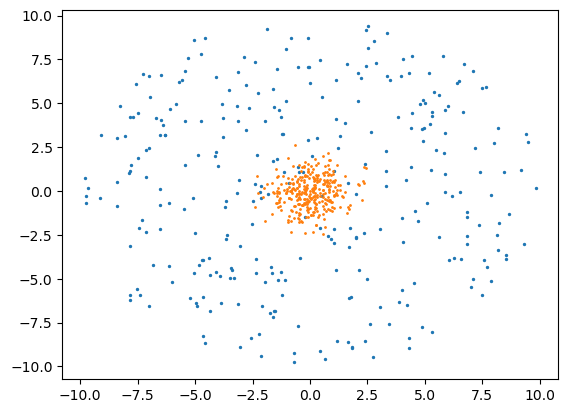

In [8]:
def generate_gaussian_plus_foreground(glxdens, bgdens, Re, router):
    nbkg = int(bgdens*router*router*4)
    bg = (np.random.rand(2, nbkg)*2-1)*router
    bgmsk = np.hypot(*bg) < router
    bg = bg[:, bgmsk]

    nglx = int(2 * glxdens * np.pi*Re**2)
    glx = np.random.randn(2, nglx)*Re/σ_to_re
    glxmsk = np.hypot(*glx) < router
    glx = glx[:, glxmsk]

    return bg, glx

bg, glx = generate_gaussian_plus_foreground(50, 1, 1, 10)

plt.scatter(*bg,s=2)
plt.scatter(*glx, s=1)
bg.shape, glx.shape


Now we need to also work out the analytic integral  for the gaussian population:

In [9]:
N,σ,r,Ro=sympy.symbols('N,σ,r,Ro',real=True, positive=True)
i = sympy.integrate(N*sympy.exp(-r**2/(2*σ**2))*r, (r, 0, Ro))*2*sympy.pi
Nsoln = sympy.solve(sympy.Eq(i, 1), N)[0]
Nsoln

exp(Ro**2/(2*σ**2))/(2*pi*σ**2*(exp(Ro**2/(2*σ**2)) - 1))

Note using that implicitly assumes the survey is centered on the galaxy, which is only true if we choose restrictive enough priors to keep it near 0,0

In [10]:
def gaussian_N(Ro, Re):
    σ = Re / σ_to_re
    x = np.exp((Ro/σ)**2)*0.5
    return 1/(2*np.pi*σ**2) / (1- 1/x)

In [11]:
param_names = 'x0,y0,Re,fbkg'.split(',')

def loglike(p, Ro, data):
    x0,y0,Re,fbkg = p
    N = gaussian_N(Ro, Re)
    σ = Re / σ_to_re

    x, y = data
    r = np.hypot(x-x0, y-y0)

    lglx = np.log(N) - 0.5 * r**2 * σ**-2
    lbkg = -np.log(np.pi*Ro**2)

    ll = np.logaddexp(np.log(fbkg) + lbkg, np.log(1-fbkg) + lglx)
    return np.sum(ll)

lpri = .1
uppri = 10
def prior_transform(u):
    x = np.empty_like(u)
    x[:2] = (u[:2]*2-1)*0.2
    x[2] = (lpri**(1-u[2]) * uppri**u[2])
    x[3] = u[3]*.9

    return x
    

In [12]:

bg, glx = generate_gaussian_plus_foreground(glxdens=25, bgdens=2, Re=1, router=10)
test_data = np.concatenate([bg, glx], axis=1)
truths = [0, 0, 1, bg.shape[1]/(bg.shape[1] + glx.shape[1])]
print('true f', truths[-1])

with dynesty.pool.Pool(15, loglike, prior_transform,
                                logl_kwargs={'data': test_data, 'Ro':10},
                      ) as pool:
    dsampler = dynesty.DynamicNestedSampler(pool.loglike, pool.prior_transform, pool=pool,
                                            ndim=len(param_names),sample='rslice')
    dsampler.run_nested(maxiter=100000,  wt_kwargs={'pfrac': 1.0})



true f 0.800761421319797


15125it [00:11, 1293.75it/s, batch: 7 | bound: 9 | nc: 1 | ncall: 467671 | eff(%):  3.117 | loglstar: -4315.954 < -4310.621 < -4311.491 | logz: -4318.496 +/-  0.071 | stop:  0.876]     


/home/erik/src/structparams_inference_biases/.pixi/envs/default/lib/python3.12/site-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


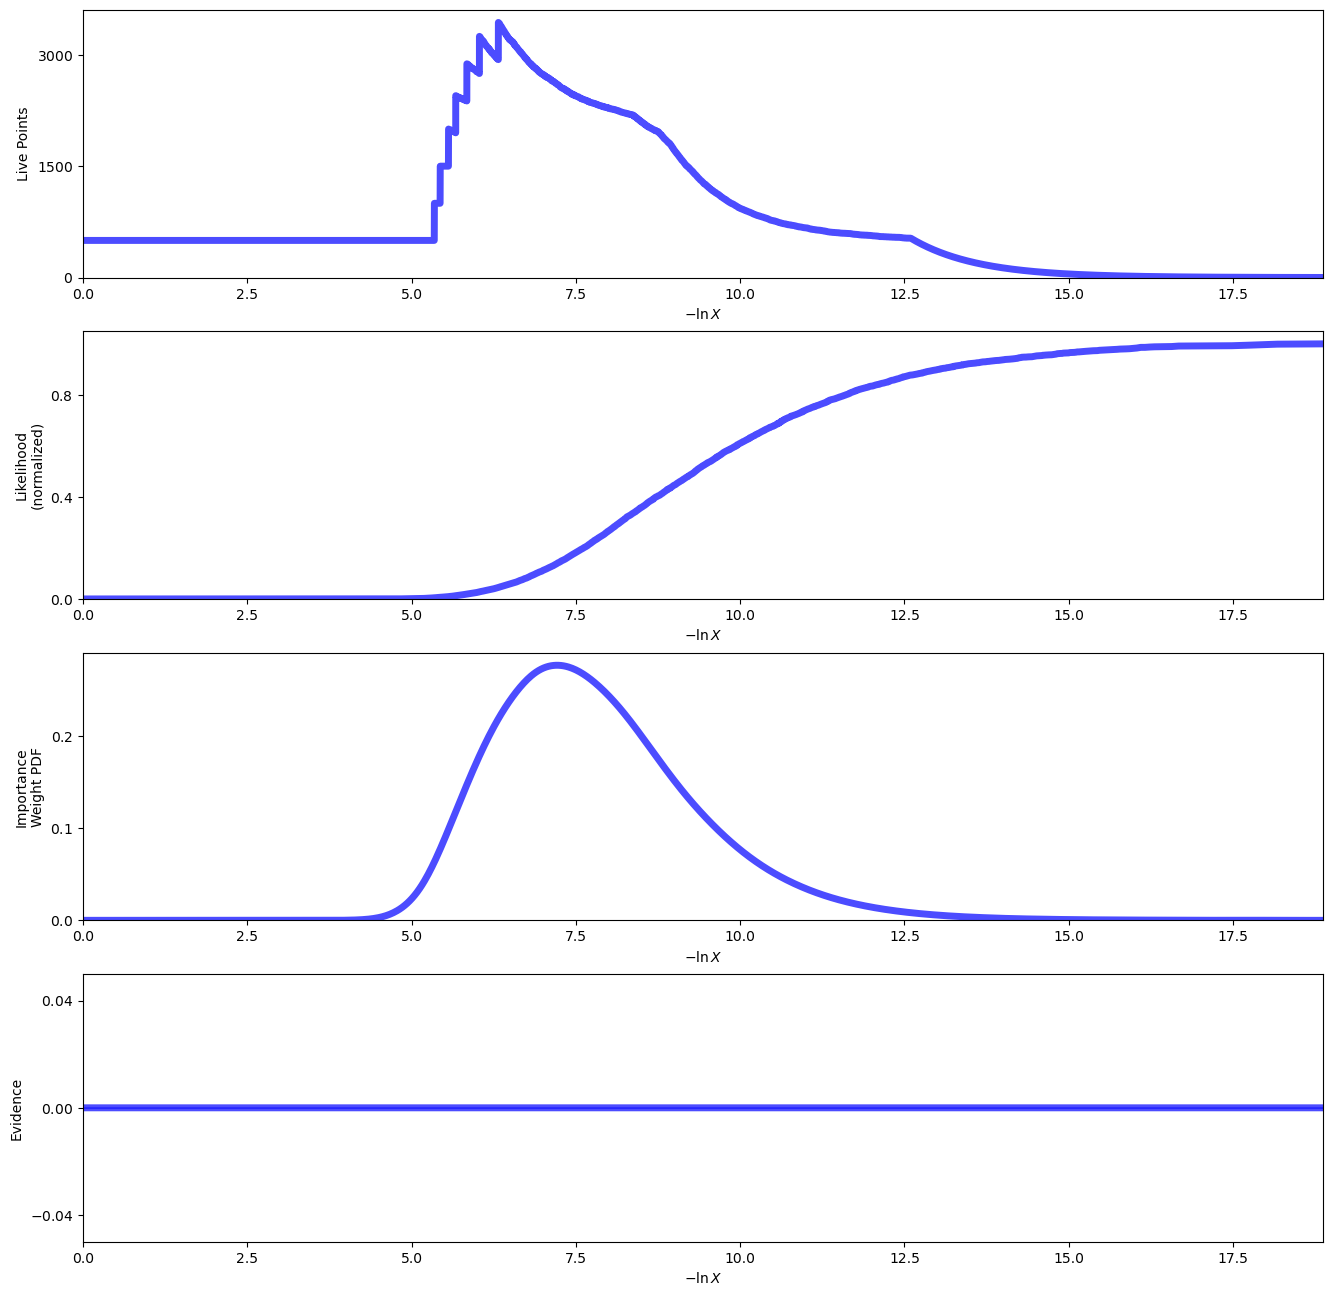

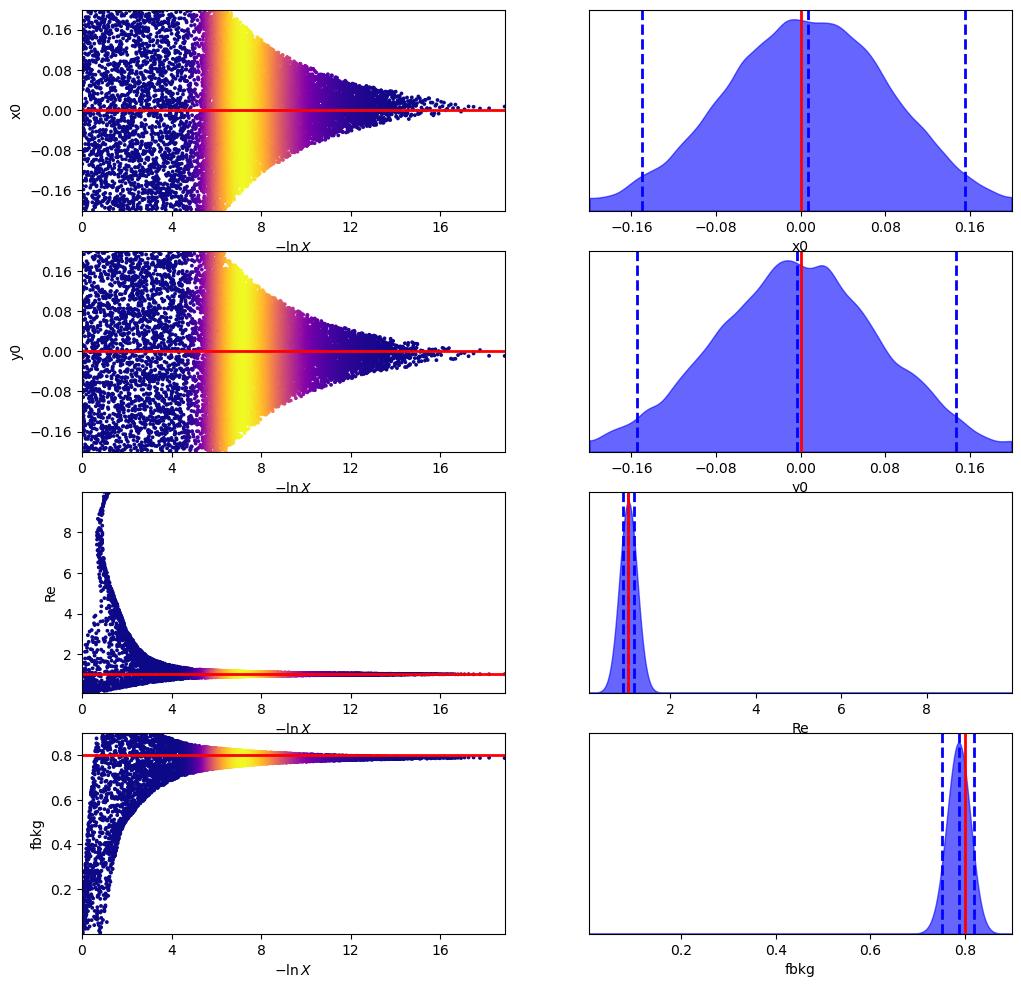

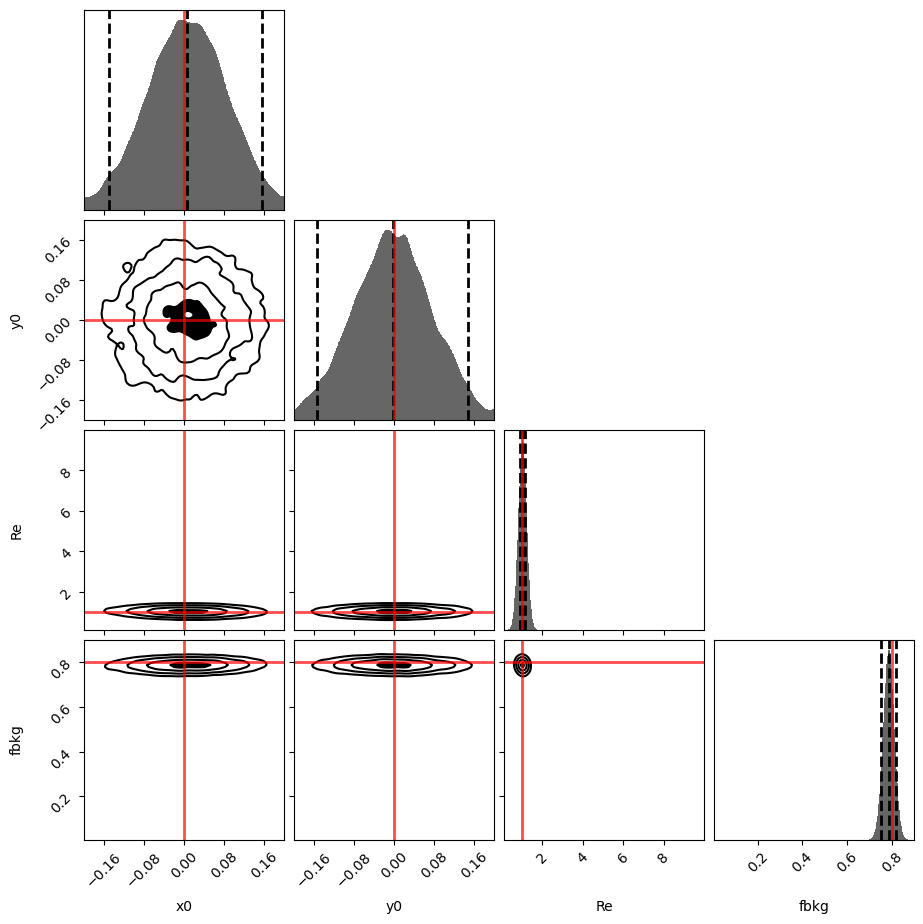

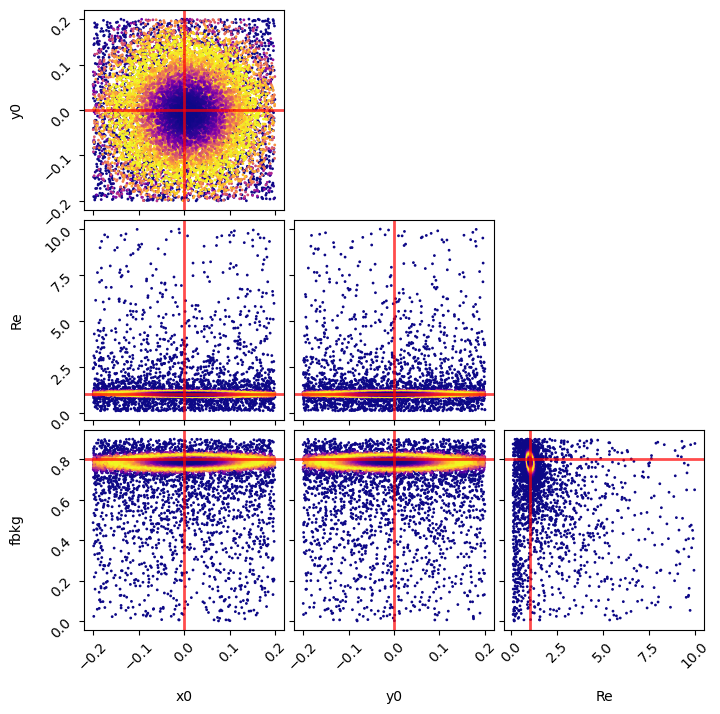

In [13]:
fig, axes = dyplot.runplot(dsampler.results)

span = [1, 1, 1, 1]

fig, axes = dyplot.traceplot(dsampler.results, labels=param_names, truths=truths,span=span)
fig, axes = dyplot.cornerplot(dsampler.results, labels=param_names, truths=truths,span=span)
fig, axes = dyplot.cornerpoints(dsampler.results, labels=param_names, truths=truths)

In [16]:
itersper = 9
ros = [2, 3, 5, 10]

results = {}
truths = {}
for ro in tqdm(ros):
    results[ro] = res = []
    truths[ro] = t = []
    for i in tqdm(list(range(itersper))):
        bg, glx = generate_gaussian_plus_foreground(glxdens=25, bgdens=2, Re=1, router=ro)
        test_data = np.concatenate([bg, glx], axis=1)
        t.append([0, 0, 1, bg.shape[1]/(bg.shape[1] + glx.shape[1])])

        with dynesty.pool.Pool(15, loglike, prior_transform,
                                        logl_kwargs={'data': test_data, 'Ro':10},
                            ) as pool:
            dsampler = dynesty.DynamicNestedSampler(pool.loglike, pool.prior_transform, pool=pool,
                                                    ndim=len(param_names),sample='auto')
            dsampler.run_nested(maxiter=100000,  wt_kwargs={'pfrac': 1.0}, print_progress=False)

        res.append(dsampler.results)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

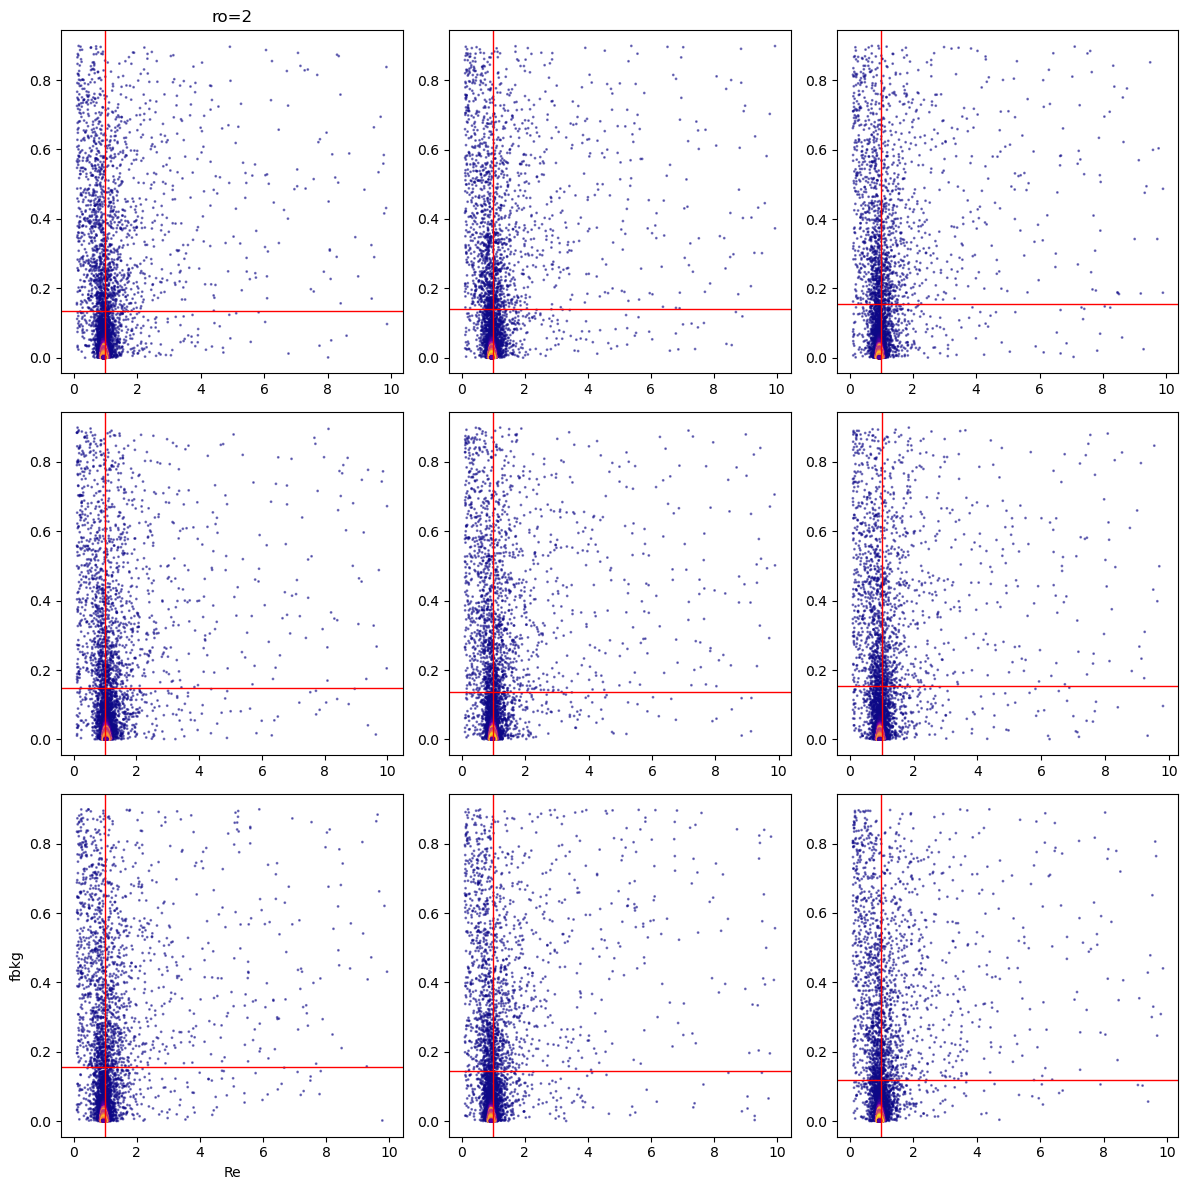

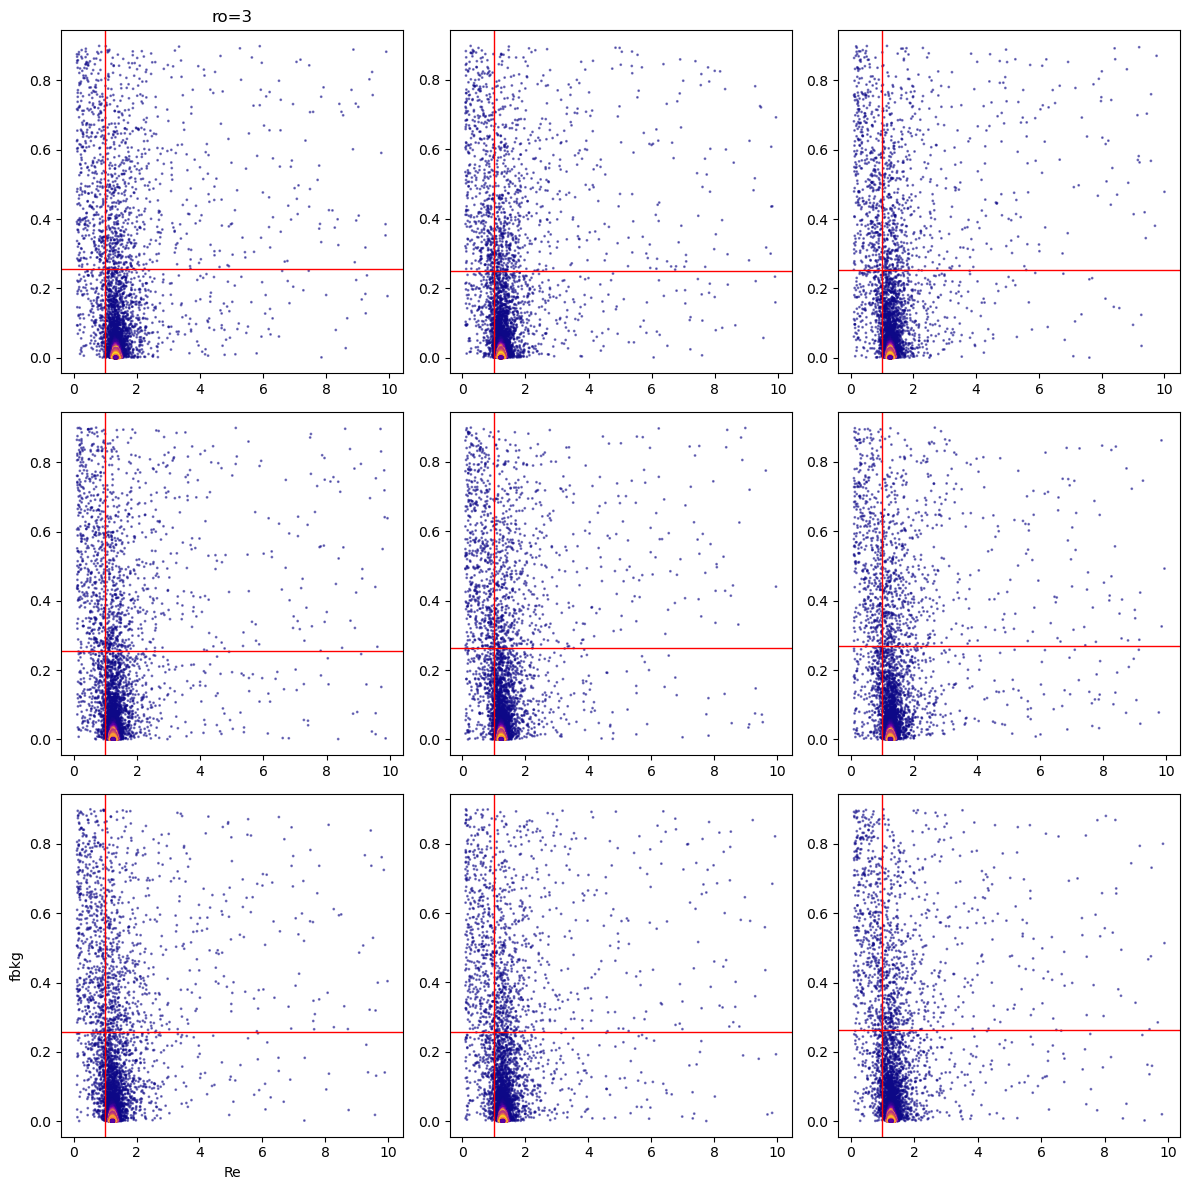

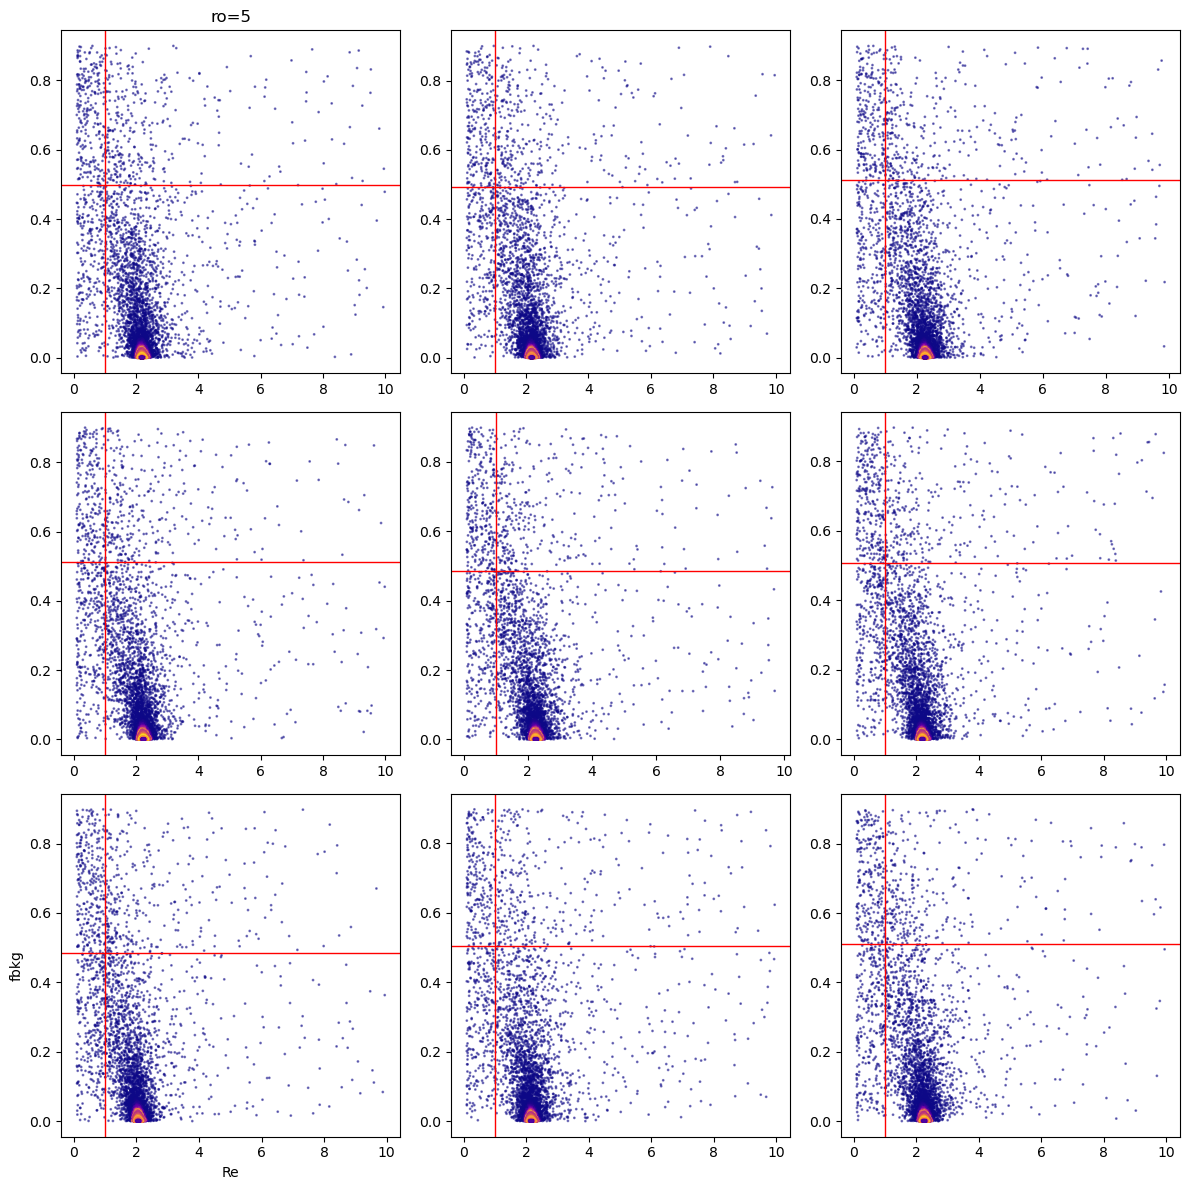

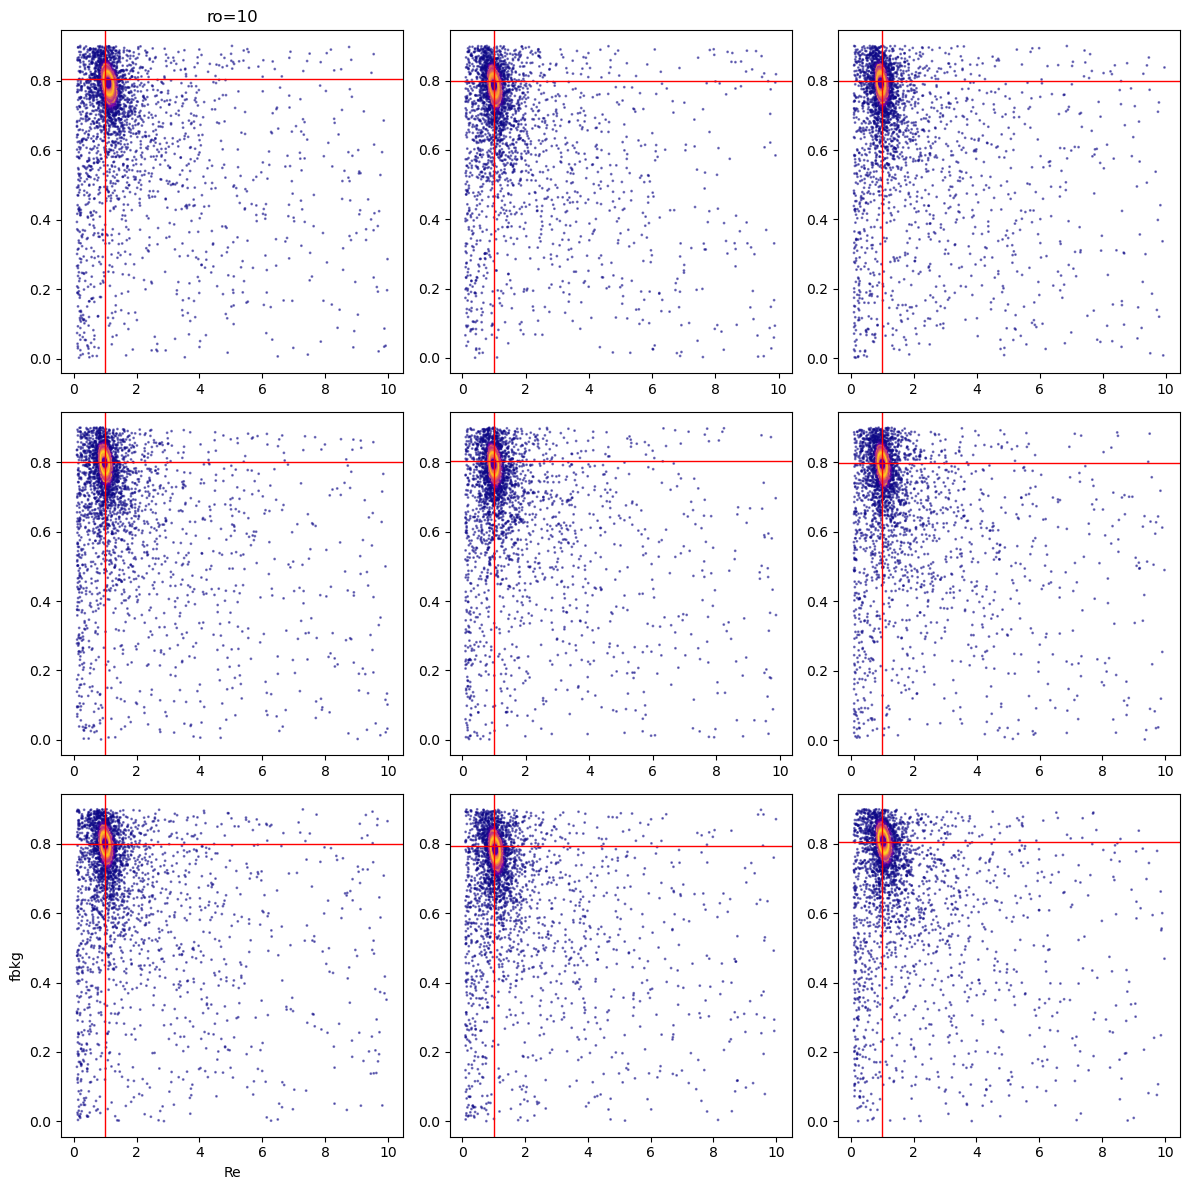

In [17]:
for ro, res in results.items():
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    for i, r in enumerate(res):
        ax = axs.ravel()[i]

        samples = r['samples']
        ws = r.importance_weights()

        ax.scatter(samples[:, 2], samples[:, 3], c=ws, alpha=.5, s=1, cmap='plasma')

        ax.axvline(truths[ro][i][2], c='r', lw=1, ls='-')
        ax.axhline(truths[ro][i][3], c='r', lw=1, ls='-')

    axs[0][0].set_title(f'ro={ro}')
    axs[-1][0].set_xlabel(param_names[2])
    axs[-1][0].set_ylabel(param_names[3])
    fig.tight_layout()

Aha, this pretty convincingly shows the strong preference for supressing one of the populations if they are similar enough.